In [ ]:
!pip install -U transformers datasets

!pip install feedparser




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:

import os
import gc
import torch
import pandas as pd
import numpy as np
import feedparser
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from datasets import Dataset

os.environ["TOKENIZERS_PARALLELISM"] = "false"
gc.collect()
torch.cuda.empty_cache()

import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
rss_urls = {
    "BBC News": "http://feeds.bbci.co.uk/news/rss.xml",
    "Reuters": "http://feeds.reuters.com/reuters/topNews",
    "NPR": "https://www.npr.org/rss/rss.php?id=1001"
}

real_news = []

for source, url in rss_urls.items():
    feed = feedparser.parse(url)
    for entry in feed.entries:
        real_news.append({"text": entry.title.strip(), "label": 1})

df_real_news = pd.DataFrame(real_news).drop_duplicates(subset="text")


In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/misinfo_project/liar/liar_train.csv")
df2 = pd.read_csv("/content/drive/MyDrive/misinfo_project/fakenewsnet/fakenewsnet_train.csv")

df_train = pd.concat([df1, df2, df_real_news], ignore_index=True)
df_train.dropna(subset=["text", "label"], inplace=True)
df_train["label"] = df_train["label"].astype(int)


df_real = df_train[df_train["label"] == 1]
df_train = pd.concat([df_train, df_real, df_real], ignore_index=True)


In [ ]:
model_name = "microsoft/deberta-v3-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding=True, max_length=512)

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.array([0, 1]), y=df_train["label"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = Dataset.from_pandas(df_train).map(tokenize, batched=True)
drop_cols = ["text"] + ([col for col in ["source"] if col in train_dataset.column_names])
train_dataset = train_dataset.remove_columns(drop_cols)
train_dataset.set_format("torch")


Map:   0%|          | 0/18323 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.5, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = nn.CrossEntropyLoss(reduction="none")(logits, targets)
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean() if self.reduction == "mean" else loss

class CustomTrainer(Trainer):
    def __init__(self, *args, use_focal=False, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.use_focal = use_focal
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").to(torch.long)
        outputs = model(**inputs)
        logits = outputs.logits

        if self.use_focal:
            loss_fn = FocalLoss(alpha=1.5, gamma=2.0)
        else:
            weight = self.class_weights.to(logits.device).to(logits.dtype)
            loss_fn = nn.CrossEntropyLoss(weight=weight)

        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

from sklearn.metrics import accuracy_score, precision_recall_fscore_support




In [ ]:
def compute_metrics(eval_pred):
    preds = torch.argmax(torch.tensor(eval_pred.predictions), axis=1)
    labels = eval_pred.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:


training_args = TrainingArguments(
    output_dir="./deberta_IT2",
    num_train_epochs=6,
    per_device_train_batch_size=2,
    learning_rate=3e-6,
    weight_decay=0.005,
    gradient_accumulation_steps=2,
    logging_steps=50,
    save_total_limit=1,
    fp16=False
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    use_focal=True,
    class_weights=class_weights
)

trainer.train()

<ipython-input-9-94530fe5ab66>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
50,0.064400
100,0.151400
150,0.117600
200,0.085600
250,0.063100
300,0.069300
350,0.018100
400,0.084900
450,0.025900
500,0.023800


TrainOutput(global_step=27486, training_loss=0.04690890646412769, metrics={'train_runtime': 11445.5001, 'train_samples_per_second': 9.605, 'train_steps_per_second': 2.401, 'total_flos': 6.634435769431875e+16, 'train_loss': 0.04690890646412769, 'epoch': 6.0})

Map:   0%|          | 0/1267 [00:00<?, ? examples/s]


🔍 Evaluation Results — LIAR
✅ Accuracy:  0.6535
✅ Precision: 0.5087
✅ Recall:    0.6526
✅ F1 Score:  0.5717


<Figure size 600x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


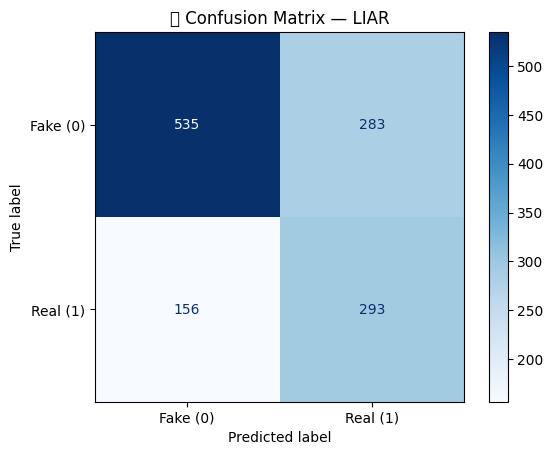

Map:   0%|          | 0/85 [00:00<?, ? examples/s]


🔍 Evaluation Results — FakeNewsNet
✅ Accuracy:  0.6000
✅ Precision: 0.5556
✅ Recall:    0.9524
✅ F1 Score:  0.7018


<Figure size 600x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


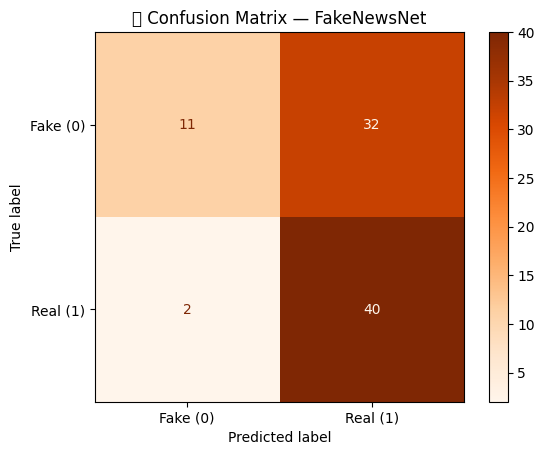

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def evaluate_model(df, dataset_name="Dataset"):
    df.dropna(subset=["text", "label"], inplace=True)
    df["label"] = df["label"].astype(int)
    eval_dataset = Dataset.from_pandas(df).map(tokenize, batched=True)
    eval_dataset = eval_dataset.remove_columns(["text"])
    eval_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    predictions = trainer.predict(eval_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), axis=1)
    labels = predictions.label_ids


    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    acc = accuracy_score(labels, preds)

    print(f"\nEvaluation Results — {dataset_name}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")


    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake (0)", "Real (1)"])
    plt.figure(figsize=(6, 5))
    disp.plot(cmap="Blues" if dataset_name == "LIAR" else "Oranges", values_format="d")
    plt.title(f"Confusion Matrix — {dataset_name}")
    plt.grid(False)
    plt.show()

    df_preds = pd.DataFrame({
        "true_label": labels,
        "predicted": preds.numpy()
    })
    df_preds.to_csv(f"{dataset_name.lower()}_test_predictions.csv", index=False)

df_liar_test = pd.read_csv("/content/drive/MyDrive/misinfo_project/liar/liar_test.csv")
df_fake_test = pd.read_csv("/content/drive/MyDrive/misinfo_project/fakenewsnet/fakenewsnet_test.csv")

evaluate_model(df_liar_test, dataset_name="LIAR")
evaluate_model(df_fake_test, dataset_name="FakeNewsNet")


In [ ]:
save_path = "/content/drive/MyDrive/misinfo_project/models/deberta_IT2"

trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)




('/content/drive/MyDrive/misinfo_project/models/deberta_IT2/tokenizer_config.json',
 '/content/drive/MyDrive/misinfo_project/models/deberta_IT2/special_tokens_map.json',
 '/content/drive/MyDrive/misinfo_project/models/deberta_IT2/spm.model',
 '/content/drive/MyDrive/misinfo_project/models/deberta_IT2/added_tokens.json',
 '/content/drive/MyDrive/misinfo_project/models/deberta_IT2/tokenizer.json')